In [1]:
# Import dependencies
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Importing the test database
twitter_df = pd.read_csv("../../res/initial_dataset.csv")
twitter_df

,Unnamed: 0,tweet_id,full_text,sentiment
0,0,1.590000e+18,@twk_5 @davidhogg111 Good question. The guns a...,anti-gun
1,1,1.590000e+18,@NikaOneDay @thegreatunkn @obiwill_kenobi @Tul...,anti-gun
2,2,1.590000e+18,Just…read this. \nhttps://t.co/TfKqT2nNZI\n\n@...,anti-gun
3,3,1.590000e+18,@TomCottonAR Are you suggesting more guns like...,anti-gun
4,4,1.590000e+18,@GhostofTST Disagreed! You can have sensible g...,anti-gun
...,...,...,...,...
995,1395,1.590000e+18,"@cbssaturday I am Dr. Floyd Jones, https://t.c...",neutral
996,1396,1.590000e+18,Future artist Tray Tray video shoot shot up in...,neutral
997,1397,1.590000e+18,Manhunt suspect in quadruple Aurora shooting t...,neutral
998,1398,1.590000e+18,"@LogicIsLeaving @phike9391 @TMZ no, i don‚Äôt....",neutral


In [4]:
# Function to clean the database
def preprocess_tweet(tweet):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    tweet = tweet.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", tweet)

    # Remove special characters
    tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", tweet)

    # Single character removal
    tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', tweet)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove URL's
    tweet = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',tweet)
    
    #Replace 2a|2nd amendment to second amendment
    tweet = re.sub("2a|2nd\samendment|2nd|2ndamendment|secondamendment", 'second amendment', tweet)
    
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    
    return tweet

In [5]:
# Save cleaned tweets in new cleaned column
cleaned_tweets = []

for tweet in twitter_df['full_text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

twitter_df['cleaned'] = pd.DataFrame(cleaned_tweets)
twitter_df.head(10)

,Unnamed: 0,tweet_id,full_text,sentiment,cleaned
0,0,1.590000e+18,@twk_5 @davidhogg111 Good question. The guns a...,anti-gun,good question the guns and rifles you used w...
1,1,1.590000e+18,@NikaOneDay @thegreatunkn @obiwill_kenobi @Tul...,anti-gun,kenobi personally d rather have time machine ...
2,2,1.590000e+18,Just…read this. \nhttps://t.co/TfKqT2nNZI\n\n@...,anti-gun,just read this on the murder of isabella thall...
3,3,1.590000e+18,@TomCottonAR Are you suggesting more guns like...,anti-gun,are you suggesting more guns like your collea...
4,4,1.590000e+18,@GhostofTST Disagreed! You can have sensible g...,anti-gun,disagreed you can have sensible gun laws or y...
5,5,1.590000e+18,"Rest in Power, Takeoff. \n\nSo sad to see anot...",anti-gun,rest in power takeoff so sad to see another vi...
6,6,1.590000e+18,@WisDems My roomate was going to date soneone ...,anti-gun,my roomate was going to date soneone until fo...
7,7,1.590000e+18,@CARebelBase Your underling premise is wrong. ...,anti-gun,your underling premise is wrong democrats nev...
8,8,1.590000e+18,@LiamMiller33 Politicians who prefer NRA paych...,anti-gun,politicians who prefer nra paychecks over pro...
9,9,1.590000e+18,@SonsOFreshOil @JOSE97LUIS @TulsiGabbard Reall...,anti-gun,really bad form does the second amendment as ...


In [6]:
# Drop column text
twitter_df = twitter_df.drop(['Unnamed: 0','tweet_id', 'full_text'], axis=1)
twitter_df

,sentiment,cleaned
0,anti-gun,good question the guns and rifles you used w...
1,anti-gun,kenobi personally d rather have time machine ...
2,anti-gun,just read this on the murder of isabella thall...
3,anti-gun,are you suggesting more guns like your collea...
4,anti-gun,disagreed you can have sensible gun laws or y...
...,...,...
995,neutral,am dr floyd jones saw chad lawson on the satu...
996,neutral,future artist tray tray video shoot shot up in...
997,neutral,manhunt suspect in quadruple aurora shooting t...
998,neutral,no don i wish could stop all gun violence tbh...


In [7]:
# Remove stopwords
import nltk
nltk.download('stopwords')
stopwordlist = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davids_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda text: cleaning_stopwords(text))
twitter_df.head()

,sentiment,cleaned
0,anti-gun,good question guns rifles used assault weapons...
1,anti-gun,kenobi personally rather time machine could go...
2,anti-gun,read murder isabella thallas denver mundanity ...
3,anti-gun,suggesting guns like colleagues gun violence e...
4,anti-gun,disagreed sensible gun laws second amendment r...


In [9]:
# Getting tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
twitter_df['cleaned'] = twitter_df['cleaned'].apply(tokenizer.tokenize)
twitter_df.head()

,sentiment,cleaned
0,anti-gun,"[good, question, guns, rifles, used, assault, ..."
1,anti-gun,"[kenobi, personally, rather, time, machine, co..."
2,anti-gun,"[read, murder, isabella, thallas, denver, mund..."
3,anti-gun,"[suggesting, guns, like, colleagues, gun, viol..."
4,anti-gun,"[disagreed, sensible, gun, laws, second, amend..."


In [10]:
# Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: stemming_on_text(x))
twitter_df.head()

,sentiment,cleaned
0,anti-gun,"[good, question, guns, rifles, used, assault, ..."
1,anti-gun,"[kenobi, personally, rather, time, machine, co..."
2,anti-gun,"[read, murder, isabella, thallas, denver, mund..."
3,anti-gun,"[suggesting, guns, like, colleagues, gun, viol..."
4,anti-gun,"[disagreed, sensible, gun, laws, second, amend..."


In [11]:
# Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: lemmatizer_on_text(x))
twitter_df.head()

,sentiment,cleaned
0,anti-gun,"[good, question, guns, rifles, used, assault, ..."
1,anti-gun,"[kenobi, personally, rather, time, machine, co..."
2,anti-gun,"[read, murder, isabella, thallas, denver, mund..."
3,anti-gun,"[suggesting, guns, like, colleagues, gun, viol..."
4,anti-gun,"[disagreed, sensible, gun, laws, second, amend..."


In [12]:
# Removing words with less frequency
# filter function to select only the words with more than 10 counts and less than 800.
import itertools
flat_list = list(itertools.chain.from_iterable(twitter_df['cleaned']))

fd = nltk.FreqDist(flat_list)
word_to_keep = list(filter(lambda x: 800>x[1]>10, fd.items()))

word_list_to_keep= [item[0] for item in word_to_keep]

def remove_lessfreq(tokanized_tweets):
    text_out = [word for word in tokanized_tweets if word in word_list_to_keep]
    return text_out

In [13]:
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: remove_lessfreq(x))
twitter_df

,sentiment,cleaned
0,anti-gun,"[good, guns, rifles, used, assault, weapons, p..."
1,anti-gun,"[time, could, go, back, prevent, guns, first, ..."
2,anti-gun,"[read, murder, gun, violence, us]"
3,anti-gun,"[guns, like, gun, violence, us, americans, gun..."
4,anti-gun,"[gun, laws, second, amendment, second, amendme..."
...,...,...
995,neutral,"[gun, violence, come]"
996,neutral,"[shot, chicago, shooting]"
997,neutral,"[shooting, say]"
998,neutral,"[could, stop, gun, violence, woman, think, kno..."


In [14]:
# Separating input feature and label
X=twitter_df.cleaned
y=twitter_df.sentiment

In [15]:
# Splitting our dataset into Train and Test Subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
# Cleaning data in single line through passing clean_text in the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 5, ngram_range=(1,5)) 
countVector = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
print(countVector.shape)

(750, 413)


In [17]:
X_train = vectorizer.transform(X_train.apply(lambda x: ' '.join(x)))
X_test  = vectorizer.transform(X_test.apply(lambda x: ' '.join(x)))

## 1.Balanced Random Forest Classifier

In [18]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators =140, random_state=1)
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)

In [19]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.6333333333333333

In [20]:
from sklearn.metrics import balanced_accuracy_score, classification_report
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

    anti-gun       0.72      0.60      0.66       100
     neutral       0.44      0.77      0.56        60
     pro-gun       0.77      0.53      0.63        90

    accuracy                           0.62       250
   macro avg       0.65      0.63      0.61       250
weighted avg       0.67      0.62      0.62       250



In [21]:
report1 = classification_report(y_test, y_pred, output_dict=True)
brfc_df = pd.DataFrame(report1).transpose()
brfc_df


,precision,recall,f1-score,support
anti-gun,0.722892,0.600000,0.655738,100.000
neutral,0.438095,0.766667,0.557576,60.000
pro-gun,0.774194,0.533333,0.631579,90.000
accuracy,0.616000,0.616000,0.616000,0.616
macro avg,0.645060,0.633333,0.614964,250.000
weighted avg,0.673009,0.616000,0.623482,250.000


In [22]:
report1 = classification_report(y_test, y_pred, output_dict=True)
brfc_df = pd.DataFrame(report1).transpose()
brfc_df


,precision,recall,f1-score,support
anti-gun,0.722892,0.600000,0.655738,100.000
neutral,0.438095,0.766667,0.557576,60.000
pro-gun,0.774194,0.533333,0.631579,90.000
accuracy,0.616000,0.616000,0.616000,0.616
macro avg,0.645060,0.633333,0.614964,250.000
weighted avg,0.673009,0.616000,0.623482,250.000


In [23]:
brfc_report_df = brfc_df.drop('support', axis=1)
brfc_report_df = brfc_report_df.head(3)
brfc_report_df = brfc_report_df.rename(columns={'precision': 'brfc_precision', 
                                  'recall': 'brfc_recall', 
                                  'f1-score': 'brfc_f1-score'})
brfc_report_df


,brfc_precision,brfc_recall,brfc_f1-score
anti-gun,0.722892,0.600000,0.655738
neutral,0.438095,0.766667,0.557576
pro-gun,0.774194,0.533333,0.631579


## 2.Bernoulli Naive Bayes

In [24]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred2 = BNBmodel.predict(X_test)

In [25]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred2)

0.5655555555555556

In [26]:
from sklearn.metrics import balanced_accuracy_score, classification_report
print("Classification Report")
print(classification_report(y_test, y_pred2))

Classification Report
              precision    recall  f1-score   support

    anti-gun       0.59      0.68      0.63       100
     neutral       0.45      0.42      0.43        60
     pro-gun       0.68      0.60      0.64        90

    accuracy                           0.59       250
   macro avg       0.57      0.57      0.57       250
weighted avg       0.59      0.59      0.59       250



In [27]:
report2 = classification_report(y_test, y_pred2, output_dict=True)
bnb_df = pd.DataFrame(report2).transpose()
bnb_df


,precision,recall,f1-score,support
anti-gun,0.591304,0.680000,0.632558,100.000
neutral,0.446429,0.416667,0.431034,60.000
pro-gun,0.683544,0.600000,0.639053,90.000
accuracy,0.588000,0.588000,0.588000,0.588
macro avg,0.573759,0.565556,0.567549,250.000
weighted avg,0.589741,0.588000,0.586531,250.000


In [28]:
bnb_report_df = bnb_df.drop('support', axis=1)
bnb_report_df = bnb_report_df.head(3)
bnb_report_df = bnb_report_df.rename(columns={'precision': 'bnb_precision', 
                                  'recall': 'bnb_recall', 
                                  'f1-score': 'bnb_f1-score'})
bnb_report_df


,bnb_precision,bnb_recall,bnb_f1-score
anti-gun,0.591304,0.680000,0.632558
neutral,0.446429,0.416667,0.431034
pro-gun,0.683544,0.600000,0.639053


## 3. Multinomial NB

In [29]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
cnb_classifier = MultinomialNB()

# Fit the classifier to the training data
cnb_classifier.fit(X_train, y_train)
y_pred3 = cnb_classifier.predict(X_test)

In [30]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred3)

0.5655555555555555

In [31]:
from sklearn.metrics import balanced_accuracy_score, classification_report
print("Classification Report")
print(classification_report(y_test, y_pred3))

Classification Report
              precision    recall  f1-score   support

    anti-gun       0.63      0.73      0.68       100
     neutral       0.43      0.33      0.38        60
     pro-gun       0.64      0.63      0.64        90

    accuracy                           0.60       250
   macro avg       0.57      0.57      0.56       250
weighted avg       0.59      0.60      0.59       250



In [32]:
report3 = classification_report(y_test, y_pred3, output_dict=True)
mnb_df = pd.DataFrame(report3).transpose()
mnb_df


,precision,recall,f1-score,support
anti-gun,0.634783,0.730000,0.679070,100.0
neutral,0.434783,0.333333,0.377358,60.0
pro-gun,0.640449,0.633333,0.636872,90.0
accuracy,0.600000,0.600000,0.600000,0.6
macro avg,0.570005,0.565556,0.564433,250.0
weighted avg,0.588823,0.600000,0.591468,250.0


In [33]:
mnb_report_df = mnb_df.drop('support', axis=1)
mnb_report_df = mnb_report_df.head(3)
mnb_report_df = mnb_report_df.rename(columns={'precision': 'mnb_precision', 
                                  'recall': 'mnb_recall', 
                                  'f1-score': 'mnb_f1-score'})
mnb_report_df


,mnb_precision,mnb_recall,mnb_f1-score
anti-gun,0.634783,0.730000,0.679070
neutral,0.434783,0.333333,0.377358
pro-gun,0.640449,0.633333,0.636872


***

# Compare Classification Reports from 3 ML Models


## Precision Comparison


In [34]:
precision_comp_df = pd.concat((brfc_report_df['brfc_precision'], 
                              bnb_report_df['bnb_precision'], 
                              mnb_report_df['mnb_precision']), 
                              axis=1, 
                              keys=['brfc_precision', 'bnb_precision', 'mnb_precision'])
precision_comp_df


,brfc_precision,bnb_precision,mnb_precision
anti-gun,0.722892,0.591304,0.634783
neutral,0.438095,0.446429,0.434783
pro-gun,0.774194,0.683544,0.640449


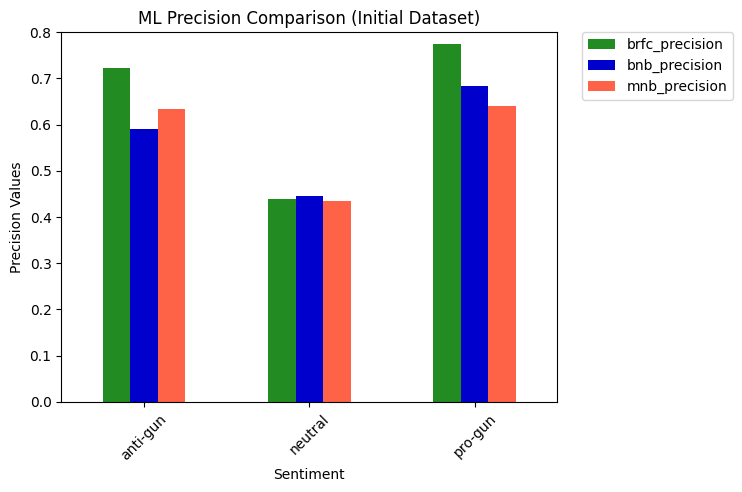

<Figure size 640x480 with 0 Axes>

In [35]:
precision_comp_df[['brfc_precision', 
                   'bnb_precision', 
                   'mnb_precision']].plot(kind="bar", 
                                           color=['forestgreen', 'mediumblue', 'tomato'])

# Set textual properties
plt.title("ML Precision Comparison (Initial Dataset)")
plt.ylabel("Precision Values")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)

# Set axis
ax = plt.gca()
ax.set_ylim([0, 0.8])

# Show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Resize plot to display labels
plt.tight_layout()


## Recall Comparison


In [36]:
recall_comp_df = pd.concat((brfc_report_df['brfc_recall'], 
                              bnb_report_df['bnb_recall'], 
                              mnb_report_df['mnb_recall']), 
                              axis=1, 
                              keys=['brfc_recall', 'bnb_recall', 'mnb_recall'])
recall_comp_df


,brfc_recall,bnb_recall,mnb_recall
anti-gun,0.600000,0.680000,0.730000
neutral,0.766667,0.416667,0.333333
pro-gun,0.533333,0.600000,0.633333


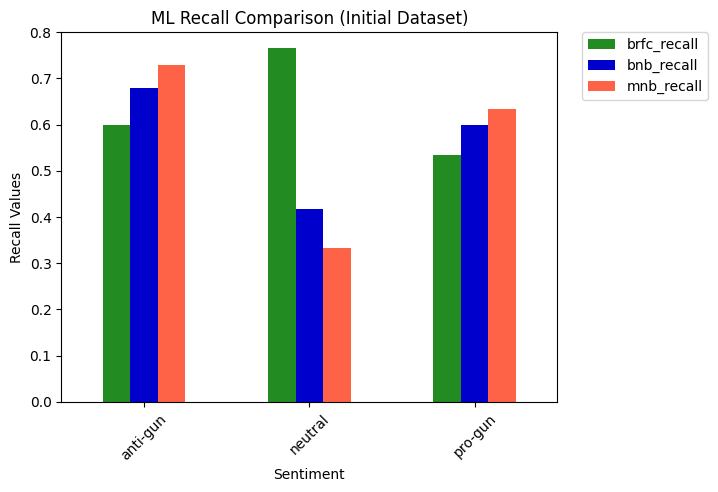

<Figure size 640x480 with 0 Axes>

In [37]:
recall_comp_df[['brfc_recall', 
                'bnb_recall', 
                'mnb_recall']].plot(kind="bar",
                                     color=['forestgreen', 'mediumblue', 'tomato'])

# Set textual properties
plt.title("ML Recall Comparison (Initial Dataset)")
plt.ylabel("Recall Values")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)

# Set axis
ax = plt.gca()
ax.set_ylim([0, 0.8])

# Show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Resize plot to display labels
plt.tight_layout()


## F1 Comparison


In [38]:
f1_comp_df = pd.concat((brfc_report_df['brfc_f1-score'], 
                              bnb_report_df['bnb_f1-score'], 
                              mnb_report_df['mnb_f1-score']), 
                              axis=1, 
                              keys=['brfc_f1_score', 'bnb_f1_score', 'mnb_f1_score'])
f1_comp_df


,brfc_f1_score,bnb_f1_score,mnb_f1_score
anti-gun,0.655738,0.632558,0.679070
neutral,0.557576,0.431034,0.377358
pro-gun,0.631579,0.639053,0.636872


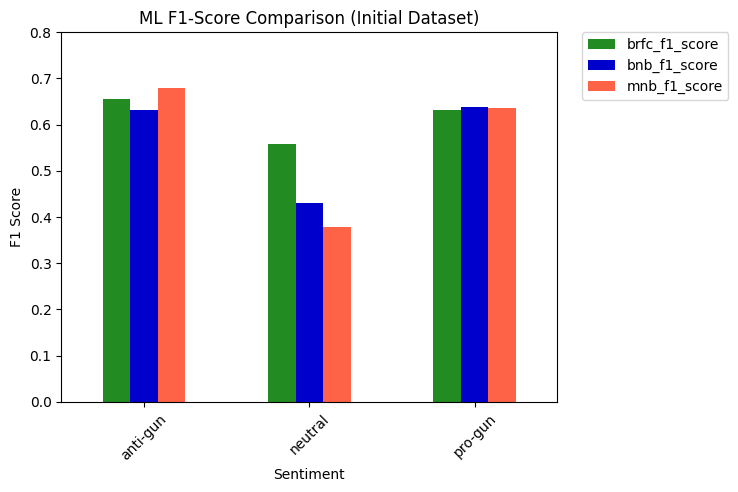

<Figure size 640x480 with 0 Axes>

In [39]:
f1_comp_df[['brfc_f1_score', 
            'bnb_f1_score', 
            'mnb_f1_score']].plot(kind="bar", 
                                  color=['forestgreen', 'mediumblue', 'tomato'])

# Set textual properties
plt.title("ML F1-Score Comparison (Initial Dataset)")
plt.ylabel("F1 Score")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)

# Set axis
ax = plt.gca()
ax.set_ylim([0, 0.8])

# Show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Resize plot to display labels
plt.tight_layout()
